- Add regularization to your CFAR-10 model (Dropout, L1, and L2)
    - dropout is inplemented in the model class
    - L2 regularization is inplemented in optimizer parameter (weight_decay)
    - L1 regularization can be inplemented by adding the term when calculating the loss in training 
- Find out how deep the model can be and still improving
    - A model with 3 hidden layers achieve an accuracy of 51.89% in test set, 
        - num_neuron_layer=1000
        - batch_size = 25
        - learn_rate=0.01 
        - final_epochs=10 
        - valid_epochs=5 
        - dropout_percent=0.1 
        - l1_reg_weight=0 #lambda
        - l2_reg_weight=0 
        - activ_func=ReLU
    - A model with 5 hidden layers achieve an accuracy of 50% in test set
        - num_neuron_layer=1200
        - batch_size = 100
        - n_iters = 8000
        - learning_rate = 0.1
        - optimizer: SGD
        - dropout :0.2 on all layers
        - l1_reg_weight=0.0001
        - l2_reg_weight=0.0001 
        - activation function :RELU
    - Couldn't train a model with similar performance for model with more layers (>=6).
- Draw confusion matrix
    - refer to test function

- Use five different optimizers and compare their results and convergence time (SGD, Adam, Adagrad, Adadelta, RMSprop) http://pytorch.org/docs/master/optim.html?highlight=optimizer#torch.optim.Optimizer
    - Adadelta converges fast at default, with comparable results with SGD
    - with default learning rate, Adagrad also has comparable results with SGD. And the curve looks more smooth
    - with default learning rate, Adam also has slightly worse results than SGD
    - with default learning rate (0.01), the accuracy of RMSprop was very bad, the accuracy is always 10% (because it is predicting everything to only one class). After changing the learning rate to 0.001, the performance was much better, although still worse than SGD. After decreasing the learning rate to 0.0005, the result was even better, almost comparable to the result of SGD. 


- Use three different activation functions (ReLu, Tanh, Sigmoid) http://pytorch.org/docs/master/nn.html?highlight=relu#torch.nn.ReLU
    - In the plots showing test accuracy changes along the training epochs (see below), it seems that Tanh is harder to train than relu: with epoch number=15, the accuracy of relu seems to be able to reach a plateau, but Tanh accuracy still increases in the last epochs, and the final accuracy result of the last epoch is still worse than relu. According to plots in which the accuracy of training and test are plotted together, it seems that the accuracies are comparable, which suggests no obvious overfitting

# Accuracy results of using different activation functions
### ReLU

<img src="acc_curve_test_ReLU.png",width=500, height=400>
<img src="acc_curve_train_test_ReLU.png",width=500, height=400>


### Tanh

<img src="acc_curve_test_Tanh.png",width=500, height=400>
<img src="acc_curve_train_test_Tanh.png",width=500, height=400>


### Sigmoid

<img src="acc_curve_test_Sigmoid.png",width=500, height=400>
<img src="acc_curve_train_test_Sigmoid.png",width=500, height=400>

# Hyperparameters:
### Except: number of hidden layers

In [1]:
num_neuron_layer=1000 #number of hidden neurons in each layer
batch_size = 50 #number of samples in each batch
learn_rate=0.01 #learning rate
momentum=0 #optimizer momentum

use_default_norm=False #use default normalization of DataLoader or not
norm_mean=0.5 #normalization mean in DataLoader
norm_std=1 #normalization std in DataLoader

final_epochs=15 #number of training epochs used for training the final model
valid_epochs=10 #number of training epochs used in each round of cross-validation
dropout_percent=0.1 #percentage dropped out in DropOut regularization in model class
l1_reg_weight=0 #weight of L1 regularization
l2_reg_weight=0 #weight of L2 regularization
lr_decay=0 #specific for Adagrad optimizer
activ_func="ReLU" #activation functions, can be "ReLU","Tanh", or "Sigmoid"
k = 5 #number of total cross-validations
optim_type="SGD" #type of optimizer, can be "SGD","Adam","Adagrad","Adadelta","RMSprop"


# Adam seems to be much slower than SGD in runtime

In [2]:
import sys
print(sys.version)

2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]


In [3]:
import torch
print(torch)

<module 'torch' from '/usr/local/lib/python2.7/dist-packages/torch/__init__.pyc'>


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets as dsets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt #in cuda 8, need to "export LC_ALL=en_US.UTF-8" in locale first, or this will result in error

from numpy.random import shuffle

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

torch.manual_seed(31)
if cuda:
    torch.cuda.manual_seed(31)

('Using PyTorch version:', '0.1.12_2', 'CUDA:', True)


## 1. Load CIFAR data and make it iterable

In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

if use_default_norm==False:
    trainset = dsets.CIFAR10('./data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((norm_mean,), (norm_std,))
                             ]))
    testset = dsets.CIFAR10('./data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((norm_mean,), (norm_std,))
                            ]))
    
else: 
    trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor(),) #use default normalization
    # transforms.ToTensor: Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
    # to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

    testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor(),)
    
train_loader = torch.utils.data.DataLoader(dataset=trainset,batch_size=batch_size, shuffle=False, **kwargs) 
"""!!!need to set shuffle=False in order to do k-fold validation, 
otherwise the data will be shuffled for every epoch"""

test_loader = torch.utils.data.DataLoader(dataset=testset,batch_size=batch_size, shuffle=True, **kwargs)


Files already downloaded and verified
Files already downloaded and verified


#### Structure of data in train_loader: X_train is the pixel data, y_train is the labels

In [6]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

('X_train:', torch.Size([50, 3, 32, 32]), 'type:', 'torch.FloatTensor')
('y_train:', torch.Size([50]), 'type:', 'torch.LongTensor')


#### Normalized images looks different from original

(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)


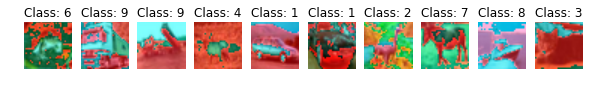

In [7]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    
    img = trainset[i][0]
    _to_pil = transforms.ToPILImage()
    
    print(img.numpy().shape)
    plt.title('Class: '+str(y_train[i]))

    plt.imshow(_to_pil(img))
plt.show()

## 2. Create model class

### With ReLU

In [8]:
if activ_func=="ReLU":
    class NeuroNet(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(NeuroNet, self).__init__()

            self.fc1 = nn.Linear(input_dim, num_neuron_layer)
            self.fc1_drop = nn.Dropout(dropout_percent)#Drop out regularization
            self.fc2 = nn.Linear(num_neuron_layer, num_neuron_layer)
            self.fc2_drop = nn.Dropout(dropout_percent)
            self.fc3 = nn.Linear(num_neuron_layer, num_neuron_layer)
            self.fc3_drop = nn.Dropout(dropout_percent)

#             self.fc4 = nn.Linear(num_neuron_layer, num_neuron_layer)
#             self.fc4_drop = nn.Dropout(dropout_percent)
#             self.fc5 = nn.Linear(num_neuron_layer, num_neuron_layer)
#             self.fc5_drop = nn.Dropout(dropout_percent)        
    #         self.fc6 = nn.Linear(num_neuron_layer, num_neuron_layer)
    #         self.fc6_drop = nn.Dropout(dropout_percent)
    #         self.fc7 = nn.Linear(num_neuron_layer, num_neuron_layer)
    #         self.fc7_drop = nn.Dropout(dropout_percent)
    #         self.fc8 = nn.Linear(num_neuron_layer, num_neuron_layer)
    #         self.fc8_drop = nn.Dropout(dropout_percent)
    #         self.fc9 = nn.Linear(num_neuron_layer, num_neuron_layer)
    #         self.fc9_drop = nn.Dropout(dropout_percent)
    #         self.fc10 = nn.Linear(num_neuron_layer, num_neuron_layer)
    #         self.fc10_drop = nn.Dropout(dropout_percent)

            self.fc4 = nn.Linear(num_neuron_layer, output_dim)

            self.relu = nn.ReLU()

        def forward(self, x):
            # The view function is meant to reshape the tensor.
            # If there is any situation that you don't know how many rows you want
            # but are sure of the number of columns then you can mention the row number as -1
            x = x.view(-1, input_dim)
            x = self.relu(self.fc1(x))
            x = self.fc1_drop(x)
            x = self.relu(self.fc2(x))
            x = self.fc2_drop(x)
            x = self.relu(self.fc3(x))
            x = self.fc3_drop(x)

#             x = self.relu(self.fc4(x))
#             x = self.fc4_drop(x)
#             x = self.relu(self.fc5(x))
#             x = self.fc5_drop(x)        
    #         x = self.relu(self.fc6(x))
    #         x = self.fc6_drop(x)
    #         x = self.relu(self.fc7(x))
    #         x = self.fc7_drop(x)
    #         x = self.relu(self.fc8(x))
    #         x = self.fc8_drop(x)
    #         x = self.relu(self.fc9(x))
    #         x = self.fc9_drop(x)
    #         x = self.relu(self.fc10(x))
    #         x = self.fc10_drop(x)


            return self.fc4(x)


### With Tanh

In [9]:
if activ_func=="Tanh":
    class NeuroNet(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(NeuroNet, self).__init__()

            self.fc1 = nn.Linear(input_dim, num_neuron_layer)
            self.fc1_drop = nn.Dropout(dropout_percent)#Drop out regularization
            self.fc2 = nn.Linear(num_neuron_layer, num_neuron_layer)
            self.fc2_drop = nn.Dropout(dropout_percent)
            self.fc3 = nn.Linear(num_neuron_layer, num_neuron_layer)
            self.fc3_drop = nn.Dropout(dropout_percent)
            
#             self.fc4 = nn.Linear(num_neuron_layer, num_neuron_layer)
#             self.fc4_drop = nn.Dropout(dropout_percent)
#             self.fc5 = nn.Linear(num_neuron_layer, num_neuron_layer)
#             self.fc5_drop = nn.Dropout(dropout_percent)

            self.fc4 = nn.Linear(num_neuron_layer, output_dim)

            self.tanh = nn.Tanh()

        def forward(self, x):
            # The view function is meant to reshape the tensor.
            # If there is any situation that you don't know how many rows you want
            # but are sure of the number of columns then you can mention the row number as -1
            x = x.view(-1, input_dim)
            x = self.tanh(self.fc1(x))
            x = self.fc1_drop(x)
            x = self.tanh(self.fc2(x))
            x = self.fc2_drop(x)
            x = self.tanh(self.fc3(x))
            x = self.fc3_drop(x)
#             x = self.tanh(self.fc4(x))
#             x = self.fc4_drop(x)
#             x = self.tanh(self.fc5(x))
#             x = self.fc5_drop(x)


            return self.fc4(x)


### With Sigmoid

In [10]:
if activ_func=="Sigmoid":
    class NeuroNet(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(NeuroNet, self).__init__()

            self.fc1 = nn.Linear(input_dim, num_neuron_layer)
            self.fc1_drop = nn.Dropout(dropout_percent)#Drop out regularization
            self.fc2 = nn.Linear(num_neuron_layer, num_neuron_layer)
            self.fc2_drop = nn.Dropout(dropout_percent)
            self.fc3 = nn.Linear(num_neuron_layer, num_neuron_layer)
            self.fc3_drop = nn.Dropout(dropout_percent)
            
#             self.fc4 = nn.Linear(num_neuron_layer, num_neuron_layer)
#             self.fc4_drop = nn.Dropout(dropout_percent)
#             self.fc5 = nn.Linear(num_neuron_layer, num_neuron_layer)
#             self.fc5_drop = nn.Dropout(dropout_percent)


            self.fc4 = nn.Linear(num_neuron_layer, output_dim)

            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            # The view function is meant to reshape the tensor.
            # If there is any situation that you don't know how many rows you want
            # but are sure of the number of columns then you can mention the row number as -1
            x = x.view(-1, input_dim)
            x = self.sigmoid(self.fc1(x))
            x = self.fc1_drop(x)
            x = self.sigmoid(self.fc2(x))
            x = self.fc2_drop(x)
            x = self.sigmoid(self.fc3(x))
            x = self.fc3_drop(x)
#             x = self.sigmoid(self.fc4(x))
#             x = self.fc4_drop(x)
#             x = self.sigmoid(self.fc5(x))
#             x = self.fc5_drop(x)



            return self.fc4(x)


## 3. Get information about dataset, and instantiate loss class

In [11]:
(a,b,c)=trainset[0][0].numpy().shape
input_dim = a*b*c #RGB
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
output_dim = len(CLASSES)#10 different classes


#loss function:
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss: This criterion combines LogSoftMax and NLLLoss in one single class.

if cuda: #use GPU
    criterion = criterion.cuda()

## 4. Learning: training, test and results printing

### Training function

In [12]:
def train(epoch, model,optimizer,return_model=False, log_interval=100):
    
    model.train() #what is this for?
    
    for batch_idx, (data, target) in enumerate(train_loader): #get one batch in every iteration
                
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad() #clear previous gradients
        output = model(data)
        
        loss = criterion(output, target)
        lossv_train.append(loss.data[0]) #for plotting loss in each iteration. 
        # Never add loss directly! It's a tensor, so this will result in a memory waste
        
        #for plotting accuracy in each iteration
        pred = output.data.max(1)[1] 
        correct = pred.eq(target.data).cpu().sum() #The number of correct predictions of this batch
        accuracy = 100. * correct / batch_size #accuracy of this batch
        accv_train.append(accuracy)
        
        if l1_reg_weight!=0:
            """L1 regularization:"""
            L1_crit=nn.L1Loss(size_average=False) #sum up pairwise absolute loss, instead of averaging
            for param in model.parameters(): #for each parameter tensor
                all_0_target=torch.zeros(param.size())
                if cuda:
                    param,all_0_target=param.cuda(),all_0_target.cuda()
                all_0_target=Variable(all_0_target)
                #param=Variable(param) #param is already a Variable
                loss+=L1_crit(param,all_0_target)*l1_reg_weight
    
        loss.backward() #Getting gradients w.r.t. parameters
        optimizer.step() #Update parameters
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
    
    if return_model==True:        
        return model #Return the model after training

### Test function

In [13]:
def test(loss_vector, accuracy_vector, model, return_conf_mat=False):
    model.eval() #what is this for?
    """
    Sets the module in evaluation mode.
    This has any effect only on modules such as Dropout or BatchNorm.
    """
    if return_conf_mat==True:
        #The confusion matrix of test
        conf_mat=np.zeros((len(CLASSES),len(CLASSES))) #len(CLASSES)=10

    test_loss, correct = 0, 0
        
    for data, target in test_loader: #No enumerate(): one batch at a time, without index
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        """Volatile is recommended for purely inference mode, when you’re sure you won’t be even calling .backward(). 
        It’s more efficient than any other autograd setting - it will use the absolute minimal amount of memory 
        to evaluate the model. volatile also determines that requires_grad is False"""
        
        output = model(data)
        test_loss += criterion(output, target).data[0] #get data (Tensor) from variable, and get the first value of the Tensor
        pred = output.data.max(1)[1] # [1]: get the index of the max output (which corresponds to max log-probability), (1) means axis=1: row-wise max
        correct += pred.eq(target.data).cpu().sum() #The number of correct predictions: torch.eq() Computes element-wise equality
        
        target_array=target.data.cpu().numpy()
        pred_array=pred.cpu().numpy()
        #print("target_array.size: {}".format(target_array.size))
        if return_conf_mat==True:
            for i in range(batch_size):
                conf_mat[target_array[i],pred_array[i]]+=1 #in conf_mat: the row is the real class, the column is the predicted class
    
    test_loss /= len(test_loader) #Average loss among all test batches
    loss_vector.append(test_loss)

    accuracy = 100. * correct / len(test_loader.dataset) #total number of correct predictions
    accuracy_vector.append(accuracy)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    
    if return_conf_mat==True:
        return conf_mat

### Training and validation function: k-fold validation

In [14]:
#def train_and_valid(epochs,k,k_idx,shuffled_idx,loss_vector, accuracy_vector, log_interval=100): 
def train_and_valid(epochs,k,k_idx,shuffled_idx,loss_matrix, accuracy_matrix,optim_type,log_interval=100): 
    #one round of cross-validation
    #training and validation together: k_idx-th round of cross-validation, with epochs training epoch in it
    #epochs: the total number of epochs, k is the total number of validation rounds
    #loss_matrix, accuracy_matrix: one row is one cross-validation, one column is one epoch
    
    #Build a new model for this round of cross-validation
    model = NeuroNet(input_dim, output_dim) #instantiate a new model for each round of cross-validation
    if cuda: #use GPU for model
        model.cuda()
    
    #create a new optimizer for this round of cross-validation
    if optim_type=="SGD":
        optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum, weight_decay=l2_reg_weight)
        # momentum helps accelerate SGD in the relevant direction and dampens oscillations.
        # It does this by adding a fraction γ of the update vector of the past time step to the current update vector
    elif optim_type=="Adam":
        optimizer = optim.Adam(model.parameters(), lr=learn_rate, weight_decay=l2_reg_weight)
    elif optim_type=="Adagrad":
        optimizer = optim.Adagrad(model.parameters(), lr=learn_rate, lr_decay=lr_decay, weight_decay=l2_reg_weight)
    elif optim_type=="Adadelta":
        optimizer = optim.Adadelta(model.parameters(), lr=learn_rate, weight_decay=l2_reg_weight)
    elif optim_type=="RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learn_rate, momentum=momentum, weight_decay=l2_reg_weight)


    valid_size=len(train_loader)/k #how many batches are inside a validation set
    batch_idx_for_validation=valid_size*k_idx #will not use these data for training
    
    valid_batches=[] #a list to store validation batches
    train_batches=[] #a list to store training batches
    
    for batch_idx, (data, target) in enumerate(train_loader): #get one batch in every iteration
        if shuffled_idx[batch_idx]>=batch_idx_for_validation and shuffled_idx[batch_idx]<batch_idx_for_validation+valid_size:
        #if batch_idx in this range, do not use for training
            valid_batches.append((data, target))
        else: train_batches.append((data, target))
    
    #print("len(valid_batches): {}".format(len(valid_batches)))### for debugging
    #print("len(train_batches): {}".format(len(train_batches)))###
    
    for epoch in range(1, epochs + 1): #repeat epoch times
        
        #training phase
        #models[k_index].train() #Sets the module in training mode. This has any effect only on modules such as Dropout or BatchNorm
        model.train() #Sets the module in training mode. This has any effect only on modules such as Dropout or BatchNorm
   
        for batch_idx, (data, target) in enumerate(train_batches): #get one batch in every iteration
            if cuda: #use GPU
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad() #clear previous gradients
            output = model(data)
            
            loss = criterion(output, target)
            if l1_reg_weight!=0:
                """L1 regularization:"""
                L1_crit=nn.L1Loss(size_average=False) #sum up pairwise absolute loss, instead of averaging
                for param in model.parameters(): #for each parameter tensor
                    all_0_target=torch.zeros(param.size())
                    if cuda:
                        param,all_0_target=param.cuda(),all_0_target.cuda()
                    all_0_target=Variable(all_0_target)
                    #param=Variable(param) #param is already a Variable
                    loss+=L1_crit(param,all_0_target)*l1_reg_weight

    
            loss.backward() #Getting gradients w.r.t. parameters
            optimizer.step() #Update parameters

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_batches)*len(data),
                    100. * batch_idx / len(train_batches), loss.data[0]))


        #Validation phase
        model.eval()#Sets the module in evaluation mode. This has any effect only on modules such as Dropout or BatchNorm

        valid_loss, correct = 0, 0

        for (data, target) in valid_batches: #get one batch in every iteration
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)

            output = model(data)
            valid_loss += criterion(output, target).data[0] #get data (Tensor) from variable, and get the first value of the Tensor
            pred = output.data.max(1)[1] # [1]: get the index of the max output (which corresponds to max log-probability), (1) means axis=1: row-wise max
            correct += pred.eq(target.data).cpu().sum() #The number of correct predictions: torch.eq() Computes element-wise equality


        valid_loss /= len(valid_batches) #Average loss among all test batches

        accuracy = 100. * correct / (len(valid_batches)*batch_size) #total number of correct predictions

        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            valid_loss, correct, len(valid_batches)*batch_size, accuracy))
        
        loss_matrix[k_idx,epoch-1]=valid_loss
        accuracy_matrix[k_idx,epoch-1]=accuracy
    
    #delete the (local) model and optimizer to free some memory
    del model
    del optimizer

### Train and validate the model of CIFAR: cross validation
#### An epoch means one pass through the whole training data. In each epoch, instantiate a new model for training, and evaluate the model using validate

In [15]:
#valid_epochs already initialized in the beginning, as one of the hyperparameters

#lossv, accv = [], [] #results of validation losses, accuracies for each round of cross validation
loss_mat=np.zeros((k,valid_epochs)) #one row is one cross-validation, one column is one epoch
acc_mat=np.zeros((k,valid_epochs))

#shuffle the batches
shuffled_idx=np.arange(len(train_loader))
shuffle(shuffled_idx)
    
for k_index in range(0, k):
    
    print("{}-th cross-validation: ".format(k_index+1))
    #train_and_valid(valid_epochs,k,k_index,shuffled_idx,lossv,accv)
    train_and_valid(valid_epochs,k,k_index,shuffled_idx,loss_mat,acc_mat,optim_type)
    
    #save the current model
    #torch.save(model.state_dict(), "model.th{}".format(k_index))
    
    k_index+=1


1-th cross-validation: 
Train Epoch: 1 [0/40000 (0%)]	Loss: 2.301514
Train Epoch: 1 [5000/40000 (12%)]	Loss: 2.301516
Train Epoch: 1 [10000/40000 (25%)]	Loss: 2.273556
Train Epoch: 1 [15000/40000 (38%)]	Loss: 2.268471
Train Epoch: 1 [20000/40000 (50%)]	Loss: 2.223705
Train Epoch: 1 [25000/40000 (62%)]	Loss: 2.218093
Train Epoch: 1 [30000/40000 (75%)]	Loss: 2.200589
Train Epoch: 1 [35000/40000 (88%)]	Loss: 2.098781

Validation set: Average loss: 2.1052, Accuracy: 2284/10000 (23%)

Train Epoch: 2 [0/40000 (0%)]	Loss: 2.150282
Train Epoch: 2 [5000/40000 (12%)]	Loss: 2.142624
Train Epoch: 2 [10000/40000 (25%)]	Loss: 1.983550
Train Epoch: 2 [15000/40000 (38%)]	Loss: 2.047760
Train Epoch: 2 [20000/40000 (50%)]	Loss: 1.923854
Train Epoch: 2 [25000/40000 (62%)]	Loss: 1.940384
Train Epoch: 2 [30000/40000 (75%)]	Loss: 1.985343
Train Epoch: 2 [35000/40000 (88%)]	Loss: 1.864771

Validation set: Average loss: 1.9132, Accuracy: 3013/10000 (30%)

Train Epoch: 3 [0/40000 (0%)]	Loss: 1.937367
Train Epo

Train Epoch: 8 [35000/40000 (88%)]	Loss: 1.451352

Validation set: Average loss: 1.5957, Accuracy: 4289/10000 (43%)

Train Epoch: 9 [0/40000 (0%)]	Loss: 1.595742
Train Epoch: 9 [5000/40000 (12%)]	Loss: 1.569217
Train Epoch: 9 [10000/40000 (25%)]	Loss: 1.620726
Train Epoch: 9 [15000/40000 (38%)]	Loss: 1.466310
Train Epoch: 9 [20000/40000 (50%)]	Loss: 1.443662
Train Epoch: 9 [25000/40000 (62%)]	Loss: 1.649714
Train Epoch: 9 [30000/40000 (75%)]	Loss: 1.739838
Train Epoch: 9 [35000/40000 (88%)]	Loss: 1.448595

Validation set: Average loss: 1.5652, Accuracy: 4432/10000 (44%)

Train Epoch: 10 [0/40000 (0%)]	Loss: 1.605021
Train Epoch: 10 [5000/40000 (12%)]	Loss: 1.567040
Train Epoch: 10 [10000/40000 (25%)]	Loss: 1.612938
Train Epoch: 10 [15000/40000 (38%)]	Loss: 1.409621
Train Epoch: 10 [20000/40000 (50%)]	Loss: 1.415893
Train Epoch: 10 [25000/40000 (62%)]	Loss: 1.676814
Train Epoch: 10 [30000/40000 (75%)]	Loss: 1.720537
Train Epoch: 10 [35000/40000 (88%)]	Loss: 1.430604

Validation set: Ave

Train Epoch: 6 [20000/40000 (50%)]	Loss: 1.781504
Train Epoch: 6 [25000/40000 (62%)]	Loss: 1.580925
Train Epoch: 6 [30000/40000 (75%)]	Loss: 1.578838
Train Epoch: 6 [35000/40000 (88%)]	Loss: 1.732542

Validation set: Average loss: 1.6636, Accuracy: 4069/10000 (41%)

Train Epoch: 7 [0/40000 (0%)]	Loss: 1.638808
Train Epoch: 7 [5000/40000 (12%)]	Loss: 1.776540
Train Epoch: 7 [10000/40000 (25%)]	Loss: 1.554891
Train Epoch: 7 [15000/40000 (38%)]	Loss: 1.598140
Train Epoch: 7 [20000/40000 (50%)]	Loss: 1.745838
Train Epoch: 7 [25000/40000 (62%)]	Loss: 1.501300
Train Epoch: 7 [30000/40000 (75%)]	Loss: 1.576850
Train Epoch: 7 [35000/40000 (88%)]	Loss: 1.713789

Validation set: Average loss: 1.6296, Accuracy: 4188/10000 (42%)

Train Epoch: 8 [0/40000 (0%)]	Loss: 1.665010
Train Epoch: 8 [5000/40000 (12%)]	Loss: 1.740836
Train Epoch: 8 [10000/40000 (25%)]	Loss: 1.520138
Train Epoch: 8 [15000/40000 (38%)]	Loss: 1.570323
Train Epoch: 8 [20000/40000 (50%)]	Loss: 1.737631
Train Epoch: 8 [25000/40000 

#### How many batches and examples in training and testing set, respectively

In [16]:
print("Number of batches in training set: {}".format(len(train_loader)))
print("Number of examples in training set: {}\n".format(len(train_loader.dataset)))
print("Number of batches in testing set: {}".format(len(test_loader)))
print("Number of examples in tesing set: {}".format(len(test_loader.dataset)))

Number of batches in training set: 1000
Number of examples in training set: 50000

Number of batches in testing set: 200
Number of examples in tesing set: 10000


#### Plot the values of validation loss and accuracy in each cross-validation

In [17]:
# print("Final validation loss of each cross-validation: {}".format(lossv))
# print("Final validation accuracy of each cross-validation: {}".format(accv))
lossv_last_epoch=loss_mat[:,valid_epochs-1].flatten() # loss vector containing the validation loss of the last epoch of each cross-validation
accv_last_epoch=acc_mat[:,valid_epochs-1].flatten() # accuracy vector containing the validation accuracy of the last epoch of each cross-validation
print("Final validation loss of each cross-validation: {}".format(lossv_last_epoch))
print("Final validation accuracy of each cross-validation: {}".format(accv_last_epoch))

Final validation loss of each cross-validation: [ 1.5282483   1.54273499  1.51344062  1.54271119  1.52890416]
Final validation accuracy of each cross-validation: [ 45.05  44.76  45.74  44.65  46.14]


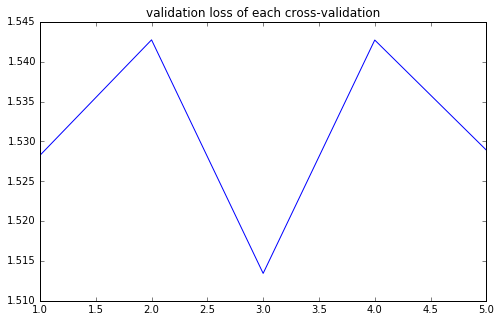

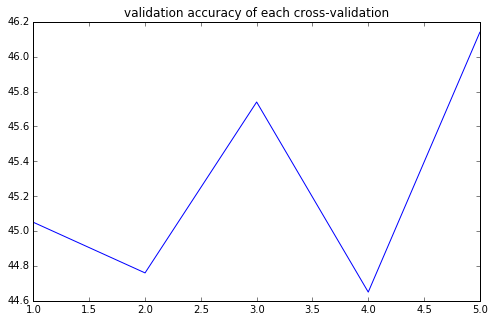

Average validation loss (%): 1.53120785463
Average validation accuracy (%): 45.268


In [18]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,k+1), lossv_last_epoch)
plt.title('validation loss of each cross-validation')

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,k+1), accv_last_epoch)
plt.title('validation accuracy of each cross-validation');
plt.show()

print("Average validation loss (%): {}".format(sum(lossv_last_epoch)/float(len(lossv_last_epoch))))
print("Average validation accuracy (%): {}".format(sum(accv_last_epoch)/float(len(accv_last_epoch))))


#### Plot the change of average cross-validation loss and accuracy with increasing epoch

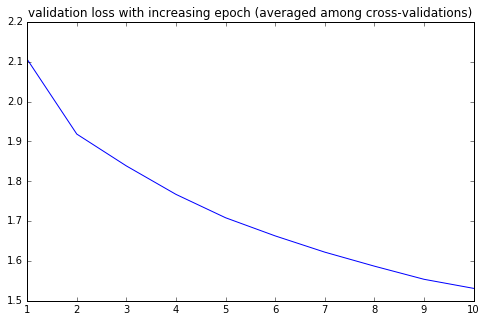

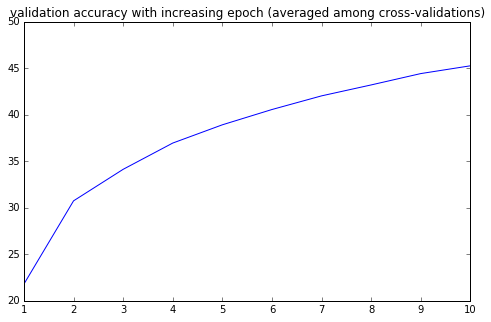

validation loss with increasing epoch (averaged among cross-validations):
[ 2.10583296  1.91828151  1.83835982  1.76699166  1.70833841  1.66282043
  1.62206347  1.58689232  1.55396551  1.53120785]
validation accuracy with increasing epoch (averaged among cross-validations):
[ 21.804  30.748  34.138  36.962  38.924  40.568  42.036  43.212  44.432
  45.268]


In [19]:
avg_lossv_each_epoch=np.mean(loss_mat,axis=0) #mean of each column: mean loss among different cross-validations
avg_accv_each_epoch=np.mean(acc_mat,axis=0) #mean of each column: mean acc among different cross-validations

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,valid_epochs+1), avg_lossv_each_epoch)
plt.title('validation loss with increasing epoch (averaged among cross-validations)')

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,valid_epochs+1), avg_accv_each_epoch)
plt.title('validation accuracy with increasing epoch (averaged among cross-validations)');
plt.show()

print("validation loss with increasing epoch (averaged among cross-validations):\n{}".format(avg_lossv_each_epoch))
print("validation accuracy with increasing epoch (averaged among cross-validations):\n{}".format(avg_accv_each_epoch))


### Train on all training data and test with test data

In [20]:
#final_epochs already initialized in the beginning, as one of the hyperparameters

#Build a new model for training
model = NeuroNet(input_dim, output_dim) #instantiate a new model for each round of cross-validation
if cuda: #use GPU for model
    model.cuda()

#create a new optimizer for this round of cross-validation
if optim_type=="SGD":
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum, weight_decay=l2_reg_weight)
    # momentum helps accelerate SGD in the relevant direction and dampens oscillations.
    # It does this by adding a fraction γ of the update vector of the past time step to the current update vector
elif optim_type=="Adam":
    optimizer = optim.Adam(model.parameters(), lr=learn_rate, weight_decay=l2_reg_weight)
elif optim_type=="Adagrad":
    optimizer = optim.Adagrad(model.parameters(), lr=learn_rate, lr_decay=lr_decay, weight_decay=l2_reg_weight)
elif optim_type=="Adadelta":
    optimizer = optim.Adadelta(model.parameters(), lr=learn_rate, weight_decay=l2_reg_weight)
elif optim_type=="RMSprop":
    optimizer = optim.RMSprop(model.parameters(), lr=learn_rate, momentum=momentum, weight_decay=l2_reg_weight)
        
lossv_test, accv_test = [], []

#vectors used for plotting all training loss along with all test loss, in order to check for overfitting
lossv_train=[]
accv_train=[]
train_iter_vector=np.arange(1,final_epochs*len(train_loader)+1)
test_iter_vector=np.arange(1*len(train_loader),final_epochs*len(train_loader)+1,len(train_loader)) #the index of training iteration when each test takes place

for epoch in range(1, final_epochs + 1):
    if epoch==final_epochs:
        trained_model=train(epoch, model, optimizer, return_model=True) #return model in the last epoch
    else: 
        train(epoch, model, optimizer)
        
    if epoch==final_epochs:
        conf_mat=test(lossv_test, accv_test, model, return_conf_mat=True) #return confusion matrix of the last epoch
    else: 
        test(lossv_test, accv_test, model)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303514
Train Epoch: 1 [5000/50000 (10%)]	Loss: 2.298292
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.285660
Train Epoch: 1 [15000/50000 (30%)]	Loss: 2.278569
Train Epoch: 1 [20000/50000 (40%)]	Loss: 2.261608
Train Epoch: 1 [25000/50000 (50%)]	Loss: 2.235281
Train Epoch: 1 [30000/50000 (60%)]	Loss: 2.161286
Train Epoch: 1 [35000/50000 (70%)]	Loss: 2.141232
Train Epoch: 1 [40000/50000 (80%)]	Loss: 2.036655
Train Epoch: 1 [45000/50000 (90%)]	Loss: 2.082326

Test set: Average loss: 2.0462, Accuracy: 2639/10000 (26%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.079515
Train Epoch: 2 [5000/50000 (10%)]	Loss: 2.018950
Train Epoch: 2 [10000/50000 (20%)]	Loss: 2.049362
Train Epoch: 2 [15000/50000 (30%)]	Loss: 1.968040
Train Epoch: 2 [20000/50000 (40%)]	Loss: 2.019271
Train Epoch: 2 [25000/50000 (50%)]	Loss: 1.940904
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.770373
Train Epoch: 2 [35000/50000 (70%)]	Loss: 1.942737
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.770744
T

Train Epoch: 15 [40000/50000 (80%)]	Loss: 1.249135
Train Epoch: 15 [45000/50000 (90%)]	Loss: 0.990910

Test set: Average loss: 1.3750, Accuracy: 5098/10000 (51%)



### Confusion matrix of the test result

In [21]:
from pandas import DataFrame
confusion_matrix=DataFrame(conf_mat,columns=CLASSES,index=CLASSES)
print(confusion_matrix)
print("Rows represent the true classes, columns represent the predicted classes")

       plane  car  bird  cat  deer  dog  frog  horse  ship  truck
plane    606   41    26    8    49    6    14     21   202     27
car       33  696     2   15    13    5    12     26   102     96
bird     128   29   257   82   240   52    97     71    33     11
cat       67   48    54  331   104  113   102     70    63     48
deer      77   26    80   40   534   19    90     81    43     10
dog       42   24    65  204   105  290    76    116    52     26
frog      22   24    46   71   186   20   555     28    32     16
horse     55   19    31   53   108   40    12    612    31     39
ship      86   66     8   10    26   10     4     12   742     36
truck     48  238     7   24    11    7    23     52   115    475
Rows represent the true classes, columns represent the predicted classes


#### Plot the change of test loss and accuracy in each epoch

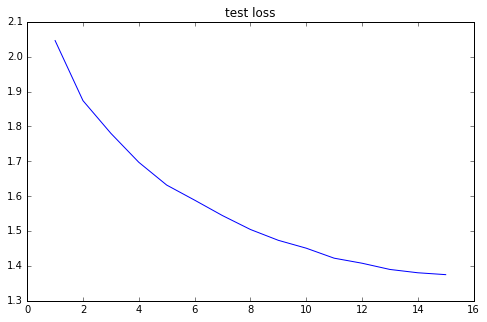

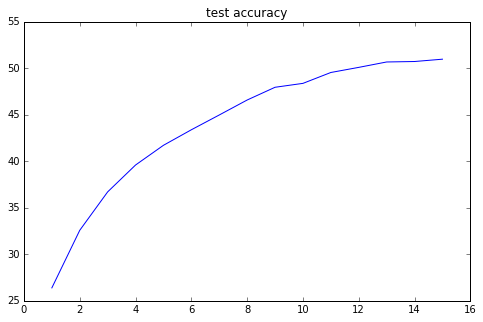

Test losses (%): [2.0461699771881103, 1.8738344925642014, 1.7801019716262818, 1.697176274061203, 1.6318450832366944, 1.5886614030599595, 1.5443184924125672, 1.5045115375518798, 1.4734505903720856, 1.4508978575468063, 1.4222441533207892, 1.4077784469723702, 1.389899332523346, 1.380394670367241, 1.3749948081374168]
Test accuracies (%): [26.39, 32.58, 36.71, 39.6, 41.72, 43.39, 44.98, 46.59, 47.96, 48.38, 49.55, 50.1, 50.68, 50.73, 50.98]


In [22]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,final_epochs+1), lossv_test)
plt.title('test loss')

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,final_epochs+1), accv_test)
plt.title('test accuracy');
plt.show()

print("Test losses (%): {}".format(lossv_test))
print("Test accuracies (%): {}".format(accv_test))

#### Calculate convergence time: with a predefined arbitrary threshold

In [23]:
"""
Relative change of accuracy: the change of accuracy between 2 neighboring training epochs 
divided by the value of accuracy of the first training epoch, and define 2 criteria for convergence:
1. use 0.015 as the threshold, once this relative change of accuracy is below this threshold, 
then regard this as a convergence;
2. The std of one change value and the one before and the one after it should be lower than 
an arbitrary threshold: 0.01
--> which mean this relative change is both small enough and also the relative changes are quite stable after it
"""
[31.92, 39.44, 42.8, 45.36, 46.73, 47.84, 49.21, 49.99, 50.81, 51.16, 52.15, 52.98, 53.57, 53.07, 53.5]
acc_relative_change=[]
for i in range(len(accv_test)-1):
    acc_relative_change.append((accv_test[i+1]-accv_test[i])/accv_test[i]) #relative change of accuracy
for i in range(0,len(acc_relative_change)-3):
    consec_3_changes=np.array([acc_relative_change[i],acc_relative_change[i+1],acc_relative_change[i+2]])
    #print(np.std(consec_3_changes))
    if np.std(consec_3_changes)<0.01 and acc_relative_change[i]<0.015:
        print("The convergence time is {} training epochs".format(i+2)) #because i starts from 0
        break
    



The convergence time is 10 training epochs


#### Plot training loss of all iterations, along with corresponding test loss
For checking if there is overfitting

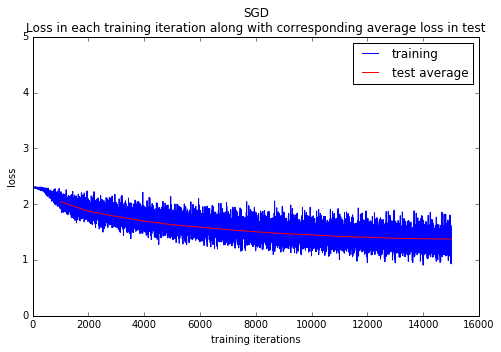

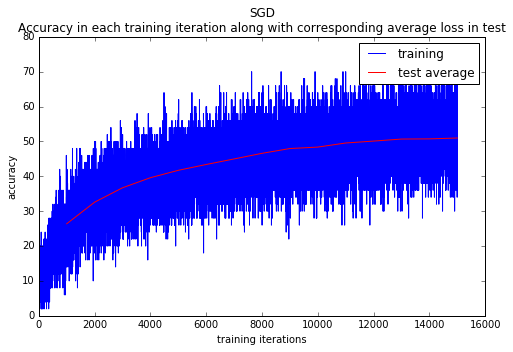

In [24]:
plt.figure(figsize=(8,5))

plt.plot(train_iter_vector, lossv_train, c='b',label="training")
plt.plot(test_iter_vector, lossv_test, c='r',label="test average")

axes = plt.gca()
axes.set_ylim([0,5])

plt.title('{}\nLoss in each training iteration along with corresponding average loss in test'.format(optim_type));
plt.xlabel('training iterations')
plt.ylabel('loss')
plt.legend()

plt.figure(figsize=(8,5))

plt.plot(train_iter_vector, accv_train, c='b',label="training")
plt.plot(test_iter_vector, accv_test, c='r',label="test average")

plt.title('{}\nAccuracy in each training iteration along with corresponding average loss in test'.format(optim_type));
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.legend()

plt.show()


#### Save model

In [25]:
# #save the final model: after adjusting hyperparameters and doing cross-validation to choose the best combination of hyperparameters
# torch.save(trained_model.state_dict(), "model.final_1000_3_layer")

# del model
# del optimizer

#### Load saved models
And print all weights and biases of the model

In [26]:
# # the_model_0 = NeuroNet(input_dim, output_dim) 
# # the_model_0.load_state_dict(torch.load("model.th0")) 
# print(the_model_0)
# for param in the_model_0.parameters():
#     print(param.data)